# Identify full image containing two given image fragments
## (image matching task using OpenCV)


In [403]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
plt.rc('text', usetex=True)

In [404]:
def visualize_two_matched_fragments(image_path, fragment_SR, fragment_WT, coordinates_SR, coordinates_WT, sample_name, i, left_margin):
    '''Function to visualize the best match for both fragments on the same image with y-proximity'''
    img_color = cv2.imread(f'{image_path}')
    h_SR, w_SR = fragment_SR.shape
    h_WT, w_WT = fragment_WT.shape

    top_left_SR = coordinates_SR
    bottom_right_SR = (top_left_SR[0] + w_SR, top_left_SR[1] + h_SR)

    top_left_WT = coordinates_WT
    bottom_right_WT = (top_left_WT[0] + w_WT, top_left_WT[1] + h_WT)

    # Draw SR rectangle in RED color
    cv2.rectangle(img_color, top_left_SR, bottom_right_SR, (0, 0, 255), 2)

    # Draw WT rectangle in GREEN color
    cv2.rectangle(img_color, top_left_WT, bottom_right_WT, (0, 255, 0), 2)

    img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis("off")

    # Create a multi-colored title using plt.figtext
    fontsize = 16  # You can adjust this value as needed
    upper_margin = 0.93
    plt.figtext(left_margin, upper_margin, "WT", color=(0, 1, 0), fontsize=fontsize)
    plt.figtext(left_margin + 0.06, upper_margin, " and ", color="black", fontsize=fontsize)
    plt.figtext(left_margin + 0.12, upper_margin, "SR", color=(1, 0, 0), fontsize=fontsize)
    plt.figtext(left_margin + 0.17, upper_margin, r" samples: $\textit{" + f"{sample_name}" + "    " + "}$ band", color="black", fontsize=fontsize)

    plt.savefig(f"../data/annotated/{sample_name.replace(' ', '_')}_annotated_{i}.svg", format='svg')
    plt.show()

In [405]:

def label_fragment(fragment, label, color, sample_name):
    '''Function to prepare small image containing fragment and its label'''

    # Load and display the WT fragment on the left panel
    fragment_rgb = cv2.cvtColor(fragment, cv2.COLOR_BGR2RGB)
    
    # Draw 1 pixel border
    # fragment_border = cv2.copyMakeBorder(fragment_rgb, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    fragment_border = fragment_rgb

    plt.figure(figsize=(1,1.3))
    plt.imshow(fragment_border)
    plt.axis('off')
    
    # Add titles
    plt.title(label, fontsize=19, color = color, ha='center', y=0.95)
    
    plt.savefig(f"../data/fragments/{sample_name}_{label}_labeled.svg", format="svg")
    plt.show()

In [406]:
sample_name_abbrev = "stath"
sample_name = 'Stathmin'
left_margin = 0.26

In [407]:
# get the current working directory and files
START_DIR = Path("./..")  # Project folder

SR_path = START_DIR / "data" / "fragments" / f"{sample_name_abbrev}_SR.png"
WT_path = START_DIR / "data" / "fragments" / f"{sample_name_abbrev}_WT.png"
FULL_IMAGE_DIR = START_DIR / "data" / "full" / "g526_g555" 

In [408]:
fragment_SR = cv2.imread(f"{SR_path}", 0)
fragment_WT = cv2.imread(f"{WT_path}", 0)

In [409]:
set_image_paths = list(FULL_IMAGE_DIR.glob("*.jpg"))

In [410]:
# Initialize dictionary to store set match results for both fragments with y-proximity
MIN_Y_DIFFERENCE = 30
MIN_X_DIFFERENCE = 50
set_match_results_proximity = {}

In [411]:
# Perform template matching for each image in the set
for image_path in set_image_paths:
    img = cv2.imread(f"{image_path}", 0)

    # Match fragment WT
    result_WT = cv2.matchTemplate(img, fragment_WT, cv2.TM_CCOEFF_NORMED)
    min_val_WT, max_val_WT, min_loc_WT, max_loc_WT = cv2.minMaxLoc(result_WT)


    # Crop the image around the matched fragment WT based on y-proximity (±MIN_Y_DIFFERENCE pixels)
    y_start = max(0, max_loc_WT[1] - MIN_Y_DIFFERENCE)
    y_end = min(img.shape[0], max_loc_WT[1] + fragment_WT.shape[0] + MIN_Y_DIFFERENCE)
    img_cropped = img[y_start:y_end, :]

    # Match fragment SR in the cropped area
    result_SR = cv2.matchTemplate(img_cropped, fragment_SR, cv2.TM_CCOEFF_NORMED)
    min_val_SR, max_val_SR, min_loc_SR, max_loc_SR = cv2.minMaxLoc(result_SR)

    # Convert the coordinates back to the original image
    max_loc_SR_original = (max_loc_SR[0], max_loc_SR[1] + y_start)

    # Store the match details if both fragments have similar "y" coordinates and do not overlap
    if abs(max_loc_SR_original[1] - max_loc_WT[1]) < MIN_Y_DIFFERENCE and abs(max_loc_SR_original[0] - max_loc_WT[0]) > MIN_X_DIFFERENCE:
        set_match_results_proximity[image_path] = {
            "coordinates_SR": max_loc_SR_original,
            "score_SR": max_val_SR,
            "coordinates_WT": max_loc_WT,
            "score_WT": max_val_WT,
            }

In [412]:
# Sort the results by average score to find the best match for both fragments on the same image with y-proximity
sorted_results_set_proximity = sorted(
    set_match_results_proximity.items(),
    key=lambda x: (x[1]["score_SR"] + x[1]["score_WT"]) / 2,
    reverse=True,
)

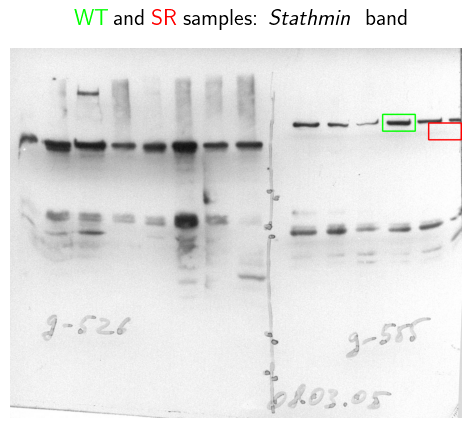

In [413]:
# Visualize the best match for both fragments on the same image in the set with y-proximity
i = 0

match_set_proximity = sorted_results_set_proximity[i][0]
coordinates_set_proximity_SR = sorted_results_set_proximity[i][1]["coordinates_SR"]
coordinates_set_proximity_WT = sorted_results_set_proximity[i][1]["coordinates_WT"]

visualize_two_matched_fragments(match_set_proximity,
    fragment_SR,
    fragment_WT,
    coordinates_set_proximity_SR,
    coordinates_set_proximity_WT,
    sample_name, 
    i,
    left_margin
)

In [414]:
# Return the best match details for both fragments on the same image in the set with y-proximity
sorted_results_set_proximity[i] if sorted_results_set_proximity else "No match found"

(PosixPath('../data/full/other/g526_f_2005_03_08_3.jpg'),
 {'coordinates_SR': (873, 156),
  'score_SR': 0.44337183237075806,
  'coordinates_WT': (777, 138),
  'score_WT': 0.6802189350128174})

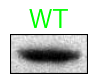

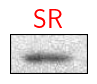

In [415]:
# Label small fragment images
label_fragment(fragment_WT, "WT", (0,1,0), sample_name_abbrev)
label_fragment(fragment_SR, "SR", (1,0,0), sample_name_abbrev)

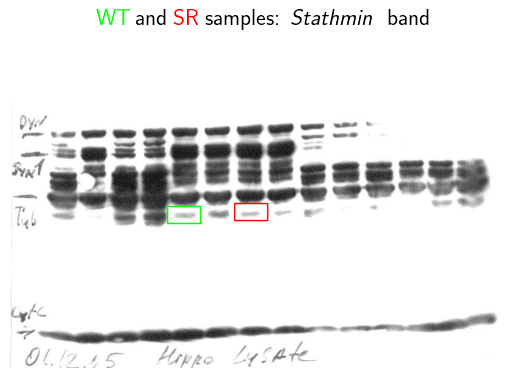

In [419]:
# Visualize next match for both fragments on the same image in the eleventh set with y-proximity
i += 1 

match_set_proximity = sorted_results_set_proximity[i][0]
coordinates_set_proximity_SR = sorted_results_set_proximity[i][1]["coordinates_SR"]
coordinates_set_proximity_WT = sorted_results_set_proximity[i][1]["coordinates_WT"]

visualize_two_matched_fragments(match_set_proximity,
    fragment_SR,
    fragment_WT,
    coordinates_set_proximity_SR,
    coordinates_set_proximity_WT,
    sample_name, 
    i,
    left_margin
)

In [417]:
# Return the best match details for both fragments on the same image in the set with y-proximity
sorted_results_set_proximity[i] if sorted_results_set_proximity else "No match found"

(PosixPath('../data/full/other/hippo_2006_04_19_4.jpg'),
 {'coordinates_SR': (235, 105),
  'score_SR': 0.45563024282455444,
  'coordinates_WT': (312, 104),
  'score_WT': 0.6613261699676514})